In [1]:
import numpy as np
import glob
import os
from opac_mixer.read import ReadOpacChubb
from opac_mixer.emulator import Emulator
import time

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

import xgboost as xg
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, STATUS_FAIL

In [2]:
R='S1'
base = f'{os.environ["pRT_input_data_path"]}/opacities/lines/corr_k'
files = glob.glob(os.path.join(base,f'*_R_{R}/*.h5'))
batchsize = int(2**16)
batchsize_test = int(2**19)

load = True
load_model = False

In [3]:
opac = ReadOpacChubb(files)
emulator = Emulator(opac)
emulator_test = Emulator(opac)

In [4]:
emulator.setup_sampling_grid(batchsize=batchsize, filename=f'data/input_{batchsize}', load=load)
emulator.setup_mix(filename=f'data/mix_R_{R}_{batchsize}', load=load, test_size=0.01);
emulator_test.setup_sampling_grid(batchsize=batchsize_test, filename=f'data/input_{batchsize_test}', load=load)
emulator_test.setup_mix(filename=f'data/mix_R_{R}_{batchsize_test}', load=load, test_size=0.99);

In [5]:
xgb_reg_params = {
    'n_estimators': hp.quniform('n_estimators', 20, 70, 1),
    'max_depth': hp.quniform('max_depth', 5, 10, 1),
    'tree_method':      'gpu_hist',
    'early_stopping_rounds': 10,
}
# Note: We may not be able to use early stopping, since results can be vary bad and that would break the fmin function

xgb_fit_params = {
    'verbose': False,
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [6]:
class HPOpt(object):
    """
    Following this example:
    https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e
    """

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        para['reg_params']['max_depth'] = int(para['reg_params']['max_depth'])
        # para['reg_params']['min_child_weight'] = int(para['reg_params']['min_child_weight'])
        para['reg_params']['n_estimators'] = int(para['reg_params']['n_estimators'])        
        
        reg = xg.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        x_train = emulator.input_scaling(self.x_train)
        x_test = emulator.input_scaling(self.x_test)

        y_train = np.log10(self.y_train)
        y_test = np.log10(self.y_test)
        
        reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], **para['fit_params'])
        t0=time.time()
        pred = reg.predict(x_test)
        t1=time.time()
        loss = para['loss_func'](y_test, pred)*(t1-t0)
        return {'loss': loss, 'status': STATUS_OK}

In [7]:
trials = Trials()

In [26]:
obj = HPOpt(emulator.X_train, emulator_test.X_test, emulator.y_train, emulator_test.y_test)

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=trials, algo=tpe.suggest, max_evals=3000)

100%|█████████▉| 2997/3000 [6:43:03<00:35, 11.95s/trial, best loss: 1.2677756524664252]   


In [28]:
trials.best_trial

{'state': 2,
 'tid': 412,
 'spec': None,
 'result': {'loss': 1.2677756524664252, 'status': 'ok'},
 'misc': {'tid': 412,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'max_depth': [412], 'n_estimators': [412]},
  'vals': {'max_depth': [5.0], 'n_estimators': [58.0]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2023, 2, 20, 18, 28, 22, 752000),
 'refresh_time': datetime.datetime(2023, 2, 20, 18, 28, 31, 579000)}

(array([617.,  18.,   7.,  62., 134.,  52.,  20.,   5.,  11.,  13.,   7.,
          4.,   3.,   7.,   3.,   2.,   2.,   4.,   1.,   1.]),
 array([ 1.26777565,  2.41213061,  3.55648558,  4.70084054,  5.8451955 ,
         6.98955046,  8.13390542,  9.27826038, 10.42261534, 11.5669703 ,
        12.71132527, 13.85568023, 15.00003519, 16.14439015, 17.28874511,
        18.43310007, 19.57745503, 20.72181   , 21.86616496, 23.01051992,
        24.15487488]),
 <BarContainer object of 20 artists>)

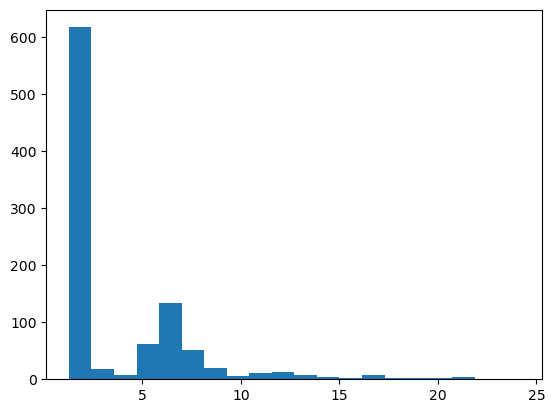

In [21]:
losses = np.asarray(trials.losses(), dtype=np.float_)
hist_cts, hist_edges = np.histogram(losses[np.isfinite(losses)])
plt.hist(losses[np.isfinite(losses)], bins=20)

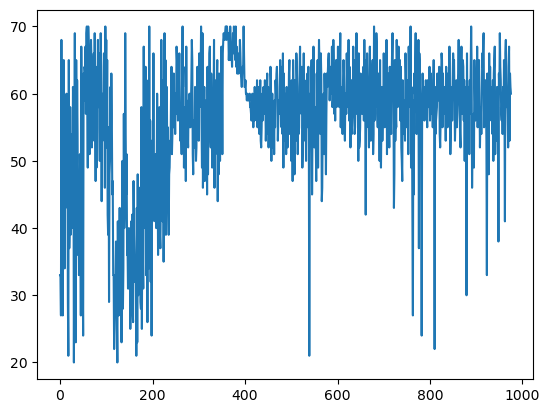

(array([ 13.,  18.,  25.,  31.,  35.,  56., 133., 254., 256., 155.]),
 array([20., 25., 30., 35., 40., 45., 50., 55., 60., 65., 70.]),
 <BarContainer object of 10 artists>)

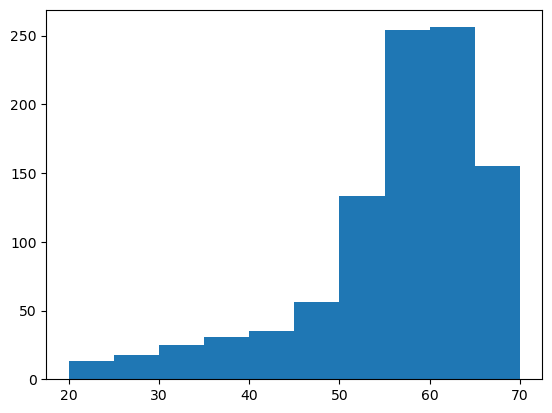

In [22]:
plt.plot(trials.vals['n_estimators'])
plt.show()
plt.hist(trials.vals['n_estimators'])

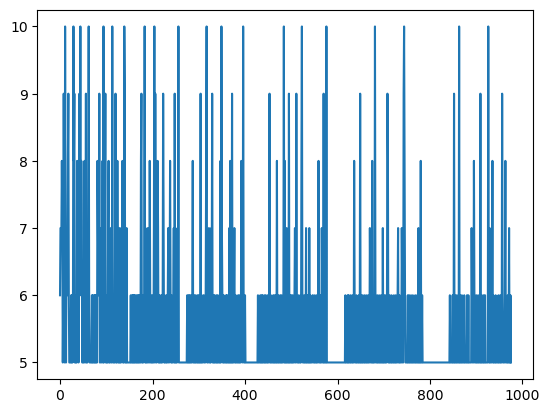

(array([638.,   0., 210.,   0.,  50.,   0.,  32.,   0.,  26.,  20.]),
 array([ 5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]),
 <BarContainer object of 10 artists>)

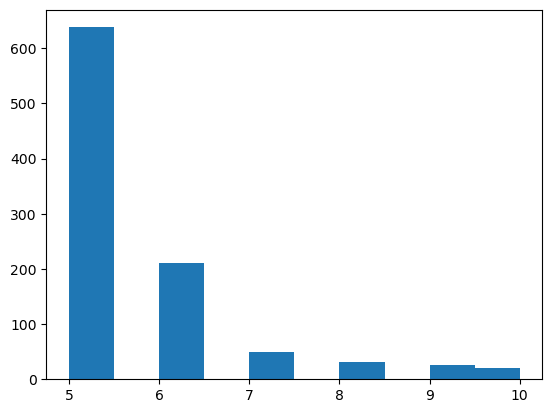

In [24]:
plt.plot(trials.vals['max_depth'])
plt.show()
plt.hist(trials.vals['max_depth'])

In [30]:
import pickle

In [31]:
with open('data/hyperopt.pickle', 'wb') as f:
    pickle.dump(trials, f)